In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
# Load your full dataset
df = pd.read_csv(r"E:\Python\Research\NextEnergy\XAI-ML-SOC-Prediction-TimeSeries\Dataset\Outcome\full_battery_data.csv")

# Optional: normalize SOC if it's in 0–100
if df["SOC"].max() > 1.0:
    df["SOC"] = df["SOC"] / 100.0

# Calculate Power
df["Power"] = df["Voltage"] * df["Current"]


In [4]:
df.head()

,Time,Voltage,Current,Temperature,SOC,DriveCycle,TemperatureLabel,Power
0,0.0,4.175155,-3.691549e-06,15.96381,1.0,PDTCB,15,-1.541279e-05
1,0.1,4.175155,-9.512327e-07,15.96381,1.0,PDTCB,15,-3.971544e-06
2,0.2,4.174967,-4.821614e-07,15.96381,1.0,PDTCB,15,-2.013008e-06
3,0.3,4.175153,-2.413463e-07,15.96381,1.0,PDTCB,15,-1.007658e-06
4,0.4,4.174966,-8.059866e-08,15.96381,1.0,PDTCB,15,-3.364967e-07


In [5]:
def create_xgboost_sequences(data, window_size=100, step=10):
    X, y = [], []
    features = ['Voltage', 'Current', 'Temperature', 'Power']
    for i in range(0, len(data) - window_size, step):
        window = data[i:i+window_size][features].values.flatten()
        target = data.iloc[i + window_size]['SOC']
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

X_all, y_all = [], []

# Apply across all drive cycles and temperatures
for (temp, cycle), group in df.groupby(['TemperatureLabel', 'DriveCycle']):
    group = group.reset_index(drop=True)
    X, y = create_xgboost_sequences(group, window_size=100, step=10)
    X_all.append(X)
    y_all.append(y)

X_all = np.concatenate(X_all)
y_all = np.concatenate(y_all)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=True, random_state=42)


In [7]:
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [8]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"R²:   {r2:.5f}")


MAE:  0.01057
RMSE: 0.01446
R²:   0.99701


In [11]:
import joblib

# Save model
joblib.dump(model, "soc_xgboost_model.pkl")

# # Load model
# loaded_model = joblib.load("soc_xgboost_model.pkl")


['soc_xgboost_model.pkl']

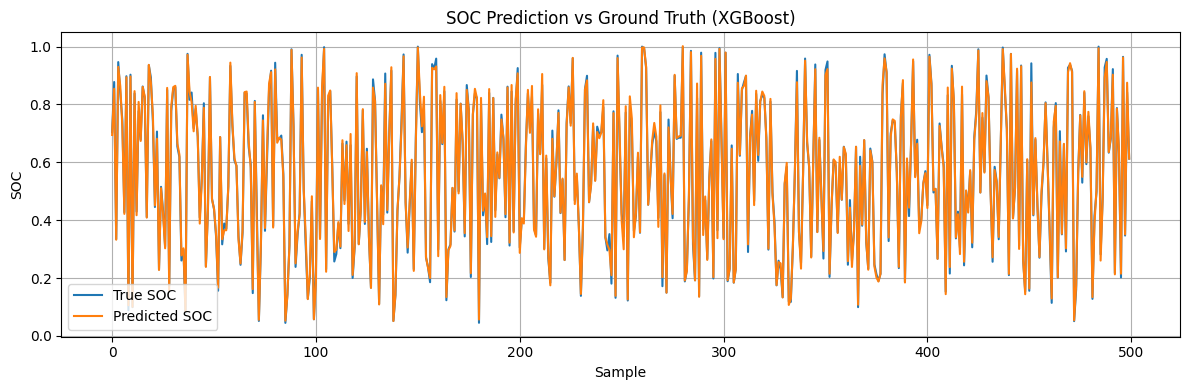

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(y_test[:500], label='True SOC')
plt.plot(y_pred[:500], label='Predicted SOC')
plt.xlabel("Sample")
plt.ylabel("SOC")
plt.title("SOC Prediction vs Ground Truth (XGBoost)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

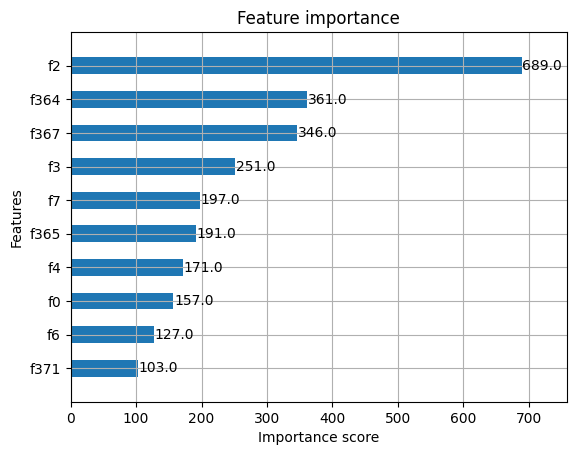

In [10]:
xgb.plot_importance(model, max_num_features=10, height=0.5)


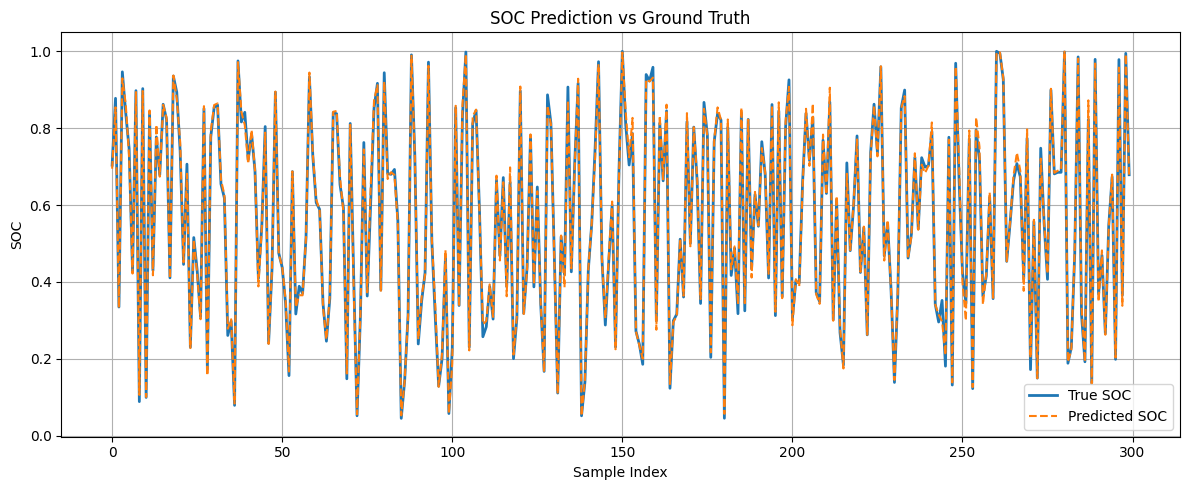

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test[:300], label='True SOC', linewidth=2)
plt.plot(y_pred[:300], label='Predicted SOC', linestyle='--')
plt.title("SOC Prediction vs Ground Truth")
plt.xlabel("Sample Index")
plt.ylabel("SOC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


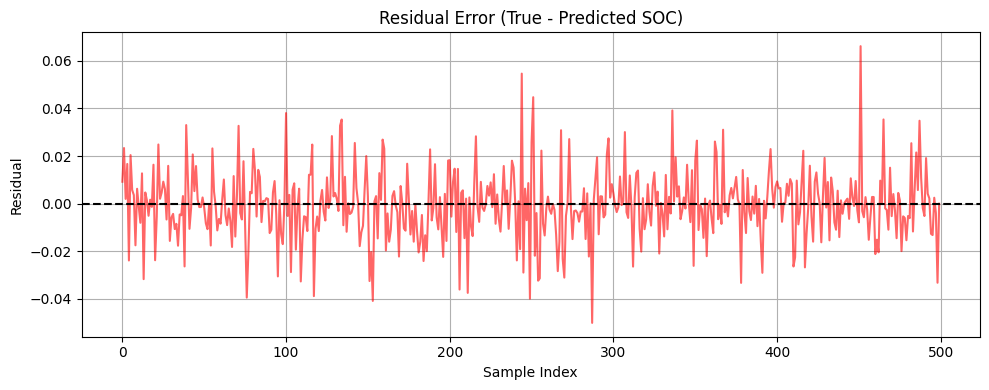

In [13]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 4))
plt.plot(residuals[:500], color='red', alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.title("Residual Error (True - Predicted SOC)")
plt.xlabel("Sample Index")
plt.ylabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.show()


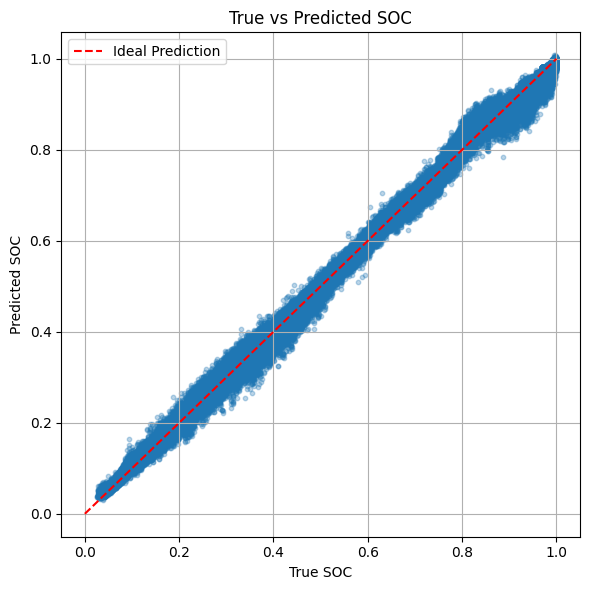

In [14]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3, s=10)
plt.plot([0, 1], [0, 1], 'r--', label='Ideal Prediction')
plt.xlabel("True SOC")
plt.ylabel("Predicted SOC")
plt.title("True vs Predicted SOC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


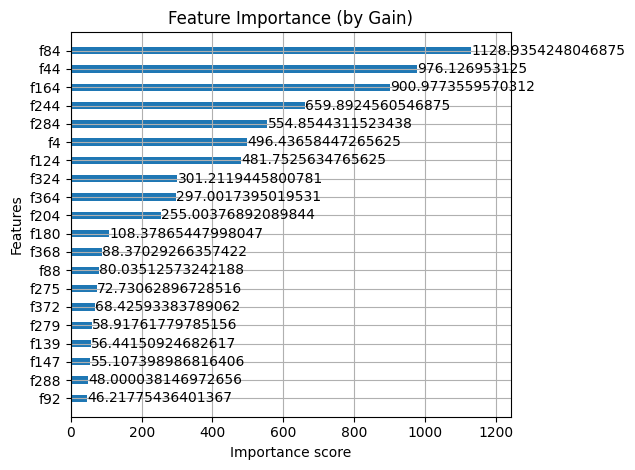

In [15]:
import xgboost as xgb

xgb.plot_importance(model, max_num_features=20, height=0.4, importance_type='gain')
plt.title("Feature Importance (by Gain)")
plt.tight_layout()
plt.show()
